In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

- finding the data not redundant with the core training dataset

In [50]:
import os
import glob

def load_name(phase, cls, les = None, data = 'sm', data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed'):
    """
    phase = 'train', 'test'
    cls: [les]  
      'n': ['neg']
      'h': ['redspot', 'angio', 'active'], 
      'd': ['ero', 'ulc', 'str'],
      'p': ['amp', 'lym', 'tum']}
    """
    lesions = dict(neg = 'negative', 
                   redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                   ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                   amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
    classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

    path = os.path.join(data_dir, data, phase, classes[cls], lesions[les])
    pathlist = glob.glob(path + '/*.jpg')
    name = []
    for i in pathlist:
        name.append(os.path.basename(i))
    return np.asarray(name)

In [55]:
neg_tr_name = load_name('train', 'n', 'neg', data = 'sm')
redspot_tr_name = load_name('train', 'h', 'redspot', data = 'sm')
angio_tr_name = load_name('train', 'h', 'angio', data = 'sm')
active_tr_name = load_name('train', 'h', 'active', data = 'sm')
ero_tr_name = load_name('train', 'd', 'ero', data = 'sm')
ulcer_tr_name = load_name('train', 'd', 'ulcer', data = 'sm')
str_tr_name = load_name('train', 'd', 'str', data = 'sm')

neg_nh_name = load_name('train', 'n', 'neg', data = 'sm_core/nh')
neg_nd_name = load_name('train', 'n', 'neg', data = 'sm_core/nd')
redspot_core_name = load_name('train', 'h', 'redspot', data = 'sm_core/nh')
angio_core_name = load_name('train', 'h', 'angio', data = 'sm_core/nh')
active_core_name = load_name('train', 'h', 'active', data = 'sm_core/nh')
ero_core_name = load_name('train', 'd', 'ero', data = 'sm_core/nd')
ulcer_core_name = load_name('train', 'd', 'ulcer', data = 'sm_core/nd')
str_core_name = load_name('train', 'd', 'str', data = 'sm_core/nd')

In [42]:
neg_nh_name = np.setdiff1d(neg_tr_name, neg_nh_name)
neg_nd_name = np.setdiff1d(neg_tr_name, neg_nd_name)

In [22]:
neg_name = np.setdiff1d(neg_tr_name, neg_nh_name)
neg_name = np.setdiff1d(neg_name, neg_nd_name)
redspot_name = np.setdiff1d(redspot_tr_name, redspot_core_name)
angio_name = np.setdiff1d(angio_tr_name, angio_core_name)
active_name = np.setdiff1d(active_tr_name, active_core_name)
ero_name = np.setdiff1d(ero_tr_name, ero_core_name)
ulcer_name = np.setdiff1d(ulcer_tr_name, ulcer_core_name)
str_name = np.setdiff1d(str_tr_name, str_core_name)

In [58]:
import cv2

def load_data_from_name(file_name, phase, cls, les = None, data = 'sm', 
                        data_dir =  '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/'):

    """
    phase = 'train', 'test'
    cls: [les]  
      'n': ['neg']
      'h': ['redspot', 'angio', 'active'], 
      'd': ['ero', 'ulc', 'str'],
      'p': ['amp', 'lym', 'tum']}
    """
    lesions = dict(neg = 'negative', 
                   redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                   ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                   amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
    classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')
    
    path = os.path.join(data_dir, data, phase, classes[cls], lesions[les])
 
    data = []

    for i in file_name:
        temp = cv2.imread(path + '/' + i)
        temp_rgb = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        data.append(temp_rgb)
    return np.asarray(data)

In [40]:
neg_img = load_data_from_name(neg_name, 'train', 'n', 'neg', data = 'sm')
redspot_img = load_data_from_name(redspot_name, 'train', 'h', 'redspot', data = 'sm')
angio_img = load_data_from_name(angio_name, 'train', 'h', 'angio', data = 'sm')
active_img = load_data_from_name(active_name, 'train', 'h', 'active', data = 'sm')
ero_img = load_data_from_name(ero_name, 'train', 'd', 'ero', data = 'sm')
ulcer_img = load_data_from_name(ulcer_name, 'train', 'd', 'ulcer', data = 'sm')
str_img = load_data_from_name(str_name, 'train', 'd', 'str', data = 'sm')

neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (42358, 512, 512, 3) (42358, 2)
red spot: (3304, 512, 512, 3) (3304, 2)
angioectasia: (75, 512, 512, 3) (75, 2)
active_bleeding: (2163, 512, 512, 3) (2163, 2)
erosion: (3392, 512, 512, 3) (3392, 2)
ulcer: (3450, 512, 512, 3) (3450, 2)
stricture: (600, 512, 512, 3) (600, 2)


# Model Inference

In [41]:
nh_path = './model/' + 'NH_core_2001041914_9540_val_acc_1.00_val_loss_0.000000'
nd_path = './model/' + 'ND_core_2001042229_12730_val_acc_1.00_val_loss_0.000018'
b_path = './model/' + 'B_core_2001042014_13950_val_acc_1.00_val_loss_0.000256'

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0106 00:01:07.304950 140516484536064 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0106 00:01:13.601441 140516484536064 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:108: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0106 00:01:13.809829 140516484536064 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [46]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 42358 / Inference Time: 00:07:10
#: 3304 / Inference Time: 00:00:34
#: 75 / Inference Time: 00:00:01
#: 2163 / Inference Time: 00:00:23
#: 3392 / Inference Time: 00:00:35
#: 3450 / Inference Time: 00:00:36
#: 600 / Inference Time: 00:00:06


In [47]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 42358 / Inference Time: 00:03:38
#: 3304 / Inference Time: 00:00:17
#: 75 / Inference Time: 00:00:00
#: 2163 / Inference Time: 00:00:11
#: 3392 / Inference Time: 00:00:17
#: 3450 / Inference Time: 00:00:17
#: 600 / Inference Time: 00:00:03


# Evaluation

In [63]:
cls = classification_metric()

## Accuracy per lesion

In [65]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 98.65 %
Accuracy: 62.11 %
Accuracy: 90.67 %
Accuracy: 93.76 %


In [66]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 97.42 %
Accuracy: 78.74 %
Accuracy: 86.58 %
Accuracy: 88.33 %


In [67]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 98.53 %
Accuracy: 60.99 %
Accuracy: 97.33 %
Accuracy: 92.23 %
Accuracy: 78.95 %
Accuracy: 78.58 %
Accuracy: 85.17 %


In [68]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 96.46 %
Accuracy: 67.43 %
Accuracy: 90.67 %
Accuracy: 96.21 %
Accuracy: 85.44 %
Accuracy: 88.67 %
Accuracy: 89.83 %


## Confusion Matrix

In [70]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

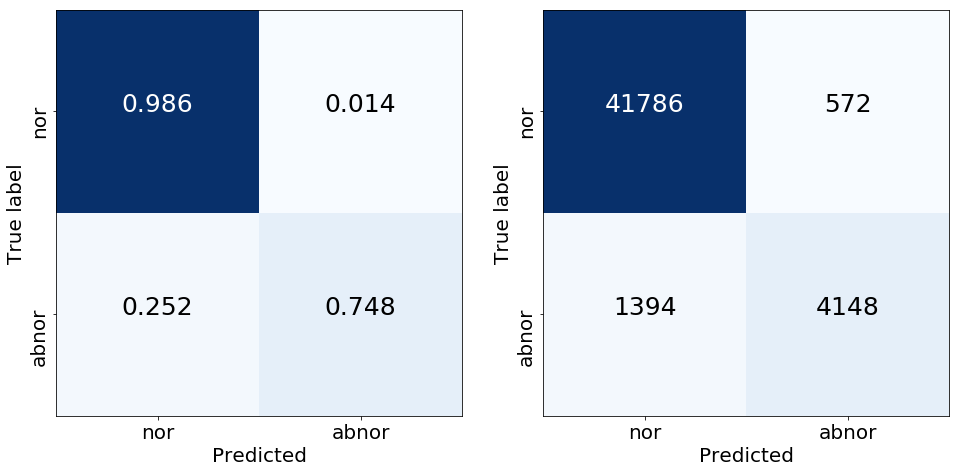

In [71]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [72]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

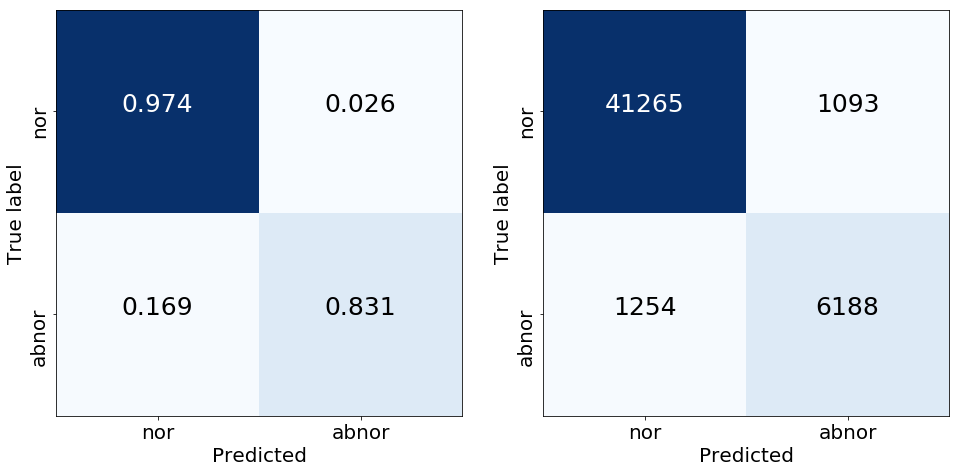

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [74]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

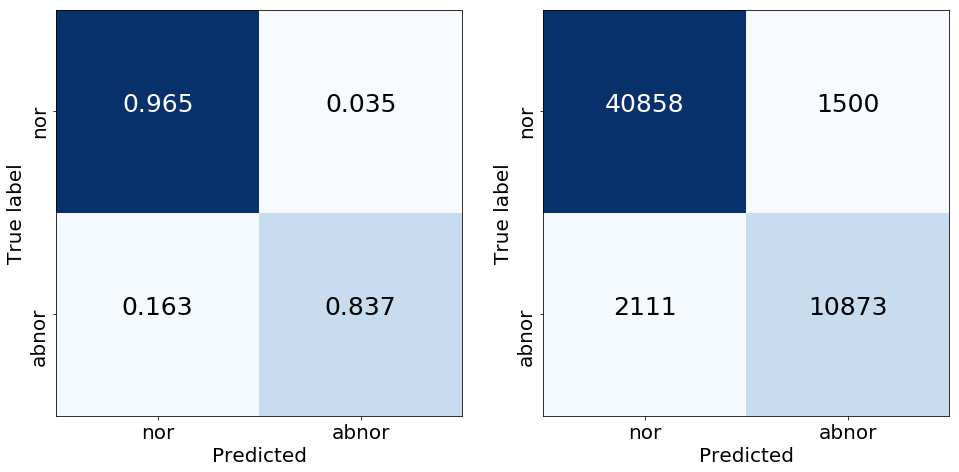

In [75]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [76]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

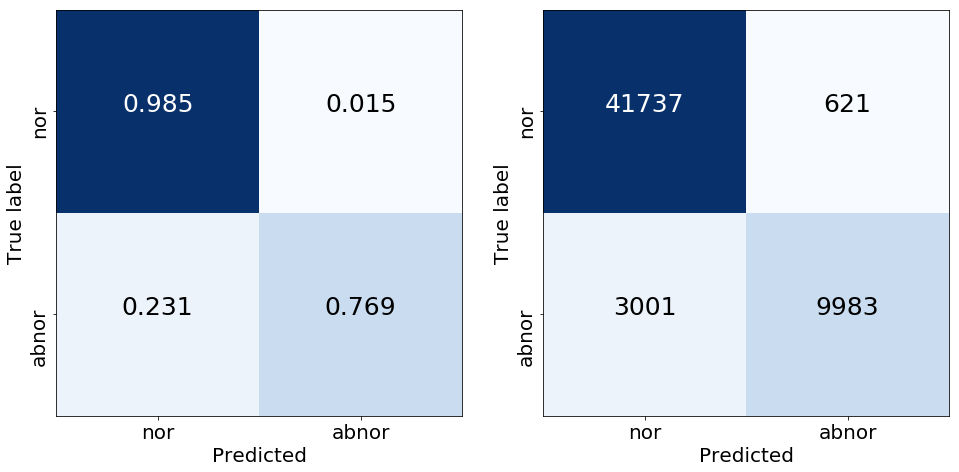

In [77]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [84]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [78]:
from sklearn.model_selection import KFold

In [79]:
def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [80]:
n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

In [81]:
from sklearn.metrics import roc_curve, auc

In [82]:
e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

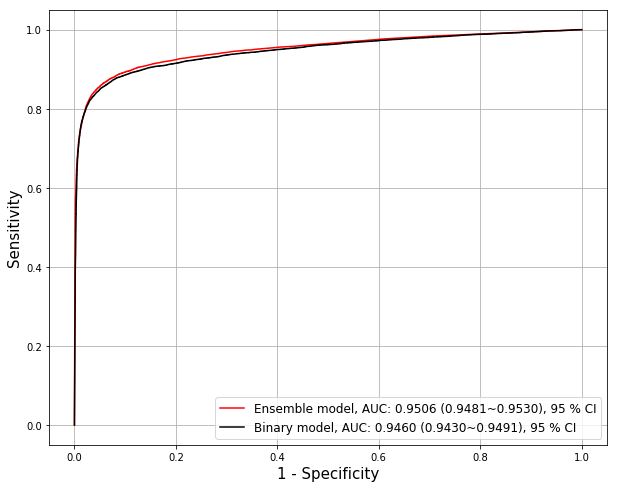

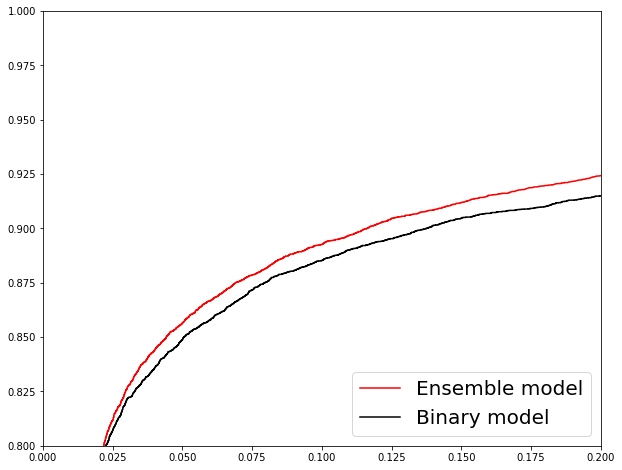

In [92]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [93]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(5537, 2)
(5537, 2)
(5536, 2)
(5535, 2)
(5534, 2)
(5533, 2)
(5533, 2)
(5533, 2)
(5532, 2)
(5532, 2)


In [94]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [95]:
b_metrices

array([[0.93552465, 0.76940815, 0.98654391, 0.93302076, 0.94612476],
       [0.93715008, 0.7840123 , 0.98418319, 0.93685393, 0.93836247],
       [0.92919075, 0.75769231, 0.98182247, 0.92959321, 0.92749529],
       [0.93803071, 0.77290223, 0.98866856, 0.93419585, 0.95437262],
       [0.93043007, 0.75808937, 0.9832389 , 0.92989507, 0.93270142],
       [0.93620098, 0.77409406, 0.98583569, 0.93443723, 0.94360902],
       [0.93330924, 0.77332305, 0.98229462, 0.93400673, 0.93042672],
       [0.93583951, 0.76715497, 0.9874882 , 0.93266444, 0.94942748],
       [0.93637021, 0.77949113, 0.98441558, 0.93580247, 0.93871866],
       [0.93347795, 0.75250578, 0.98890201, 0.92880905, 0.9540567 ]])

In [96]:
e_metrices

array([[0.93877551, 0.8501153 , 0.96600567, 0.95451365, 0.8848    ],
       [0.93751129, 0.85395849, 0.9631728 , 0.95550351, 0.87687451],
       [0.93190029, 0.82769231, 0.96388102, 0.94799164, 0.87550854],
       [0.93586269, 0.83294842, 0.9674221 , 0.94971031, 0.88688525],
       [0.92952656, 0.83204931, 0.95939566, 0.94908921, 0.86261981],
       [0.93330924, 0.83037779, 0.96482531, 0.94892036, 0.87846656],
       [0.93457437, 0.84117194, 0.9631728 , 0.95193654, 0.87489976],
       [0.93475511, 0.83654588, 0.96482531, 0.95068621, 0.87925446],
       [0.93618944, 0.84040093, 0.96552538, 0.95181564, 0.88187702],
       [0.93510484, 0.82883577, 0.96765053, 0.94861111, 0.8869637 ]])

In [97]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 93.46 (93.25 ~ 93.66)
Sen --- 76.89 (76.16 ~ 77.61)
Spec --- 98.53 (98.35 ~ 98.72)
NPV --- 93.29 (93.10 ~ 93.49)
PPV --- 94.15 (93.47 ~ 94.84)

Ensemble model
Accr --- 93.48 (93.28 ~ 93.67)
Sen --- 83.74 (83.10 ~ 84.38)
Spec --- 96.46 (96.29 ~ 96.63)
NPV --- 95.09 (94.91 ~ 95.27)
PPV --- 87.88 (87.36 ~ 88.40)


### Equal-Variance Test

In [98]:
from scipy.stats import bartlett

In [99]:
accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 0.054, pvalue=0.816961272938
bartlett test for sensitivity: 0.118, pvalue=0.731357605446
bartlett test for specificity: 0.029, pvalue=0.864118313167
bartlett test for negative predictive values: 0.032, pvalue=0.859019347049
bartlett test for positive predictive values: 0.672, pvalue=0.412506378700


In [100]:
from scipy.stats import levene

In [101]:
accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.068, pvalue=0.797902211872
levene test for sensitivity: 0.105, pvalue=0.750028779030
levene test for specificity: 0.503, pvalue=0.487104226932
levene test for negative predictive values: 0.027, pvalue=0.871609275945
levene test for positive predictive values: 1.852, pvalue=0.190341937329


### Normality Test

In [102]:
from scipy.stats import ks_2samp

In [103]:
accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.200, pvalue=0.994457554829
Kolmogorov-Smirnov test for sensitivity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for negative predictive values: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for positive predictive values: 1.000, pvalue=0.000010825088


### Wilcoxon signed-ranks test (not normal and paired group)

In [104]:
from scipy.stats import wilcoxon

In [105]:
accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 24.000, pvalue=0.721276699029
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [106]:
from scipy.stats import ttest_rel

In [107]:
accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -0.310, pvalue=0.763841878887
t-statistics for sensitivity: -28.407, pvalue=0.000000000404
t-statistics for specificity: 37.269, pvalue=0.000000000036
t-statistics for negative predictive values: -26.949, pvalue=0.000000000646
t-statistics for positive predictive values: 31.252, pvalue=0.000000000172


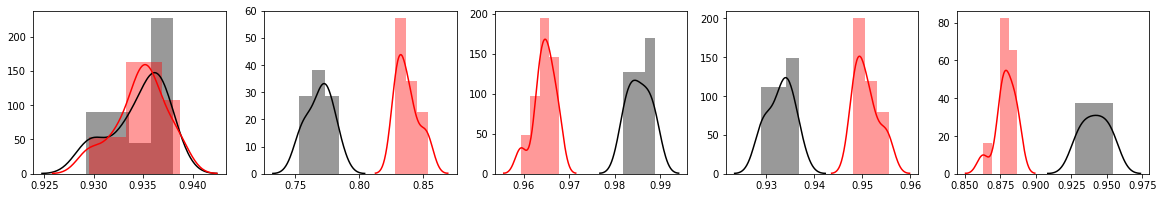

In [108]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

sns.set_style({'axes.grid' : True})

fig.show()